In [13]:
import torch 
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sys

sys.path.append('../')
import xfinai_config
from data_layer.create_data_loader import FuturesDataset

### 0 Loading DL

In [14]:
# Load Dataloader
train_dataloader_list = joblib.load('../data_layer/data_loaders/train_dataloader_list.pkl')
val_dataloader_list = joblib.load('../data_layer/data_loaders/val_dataloader_list.pkl')
test_dataloader_list = joblib.load('../data_layer/data_loaders/test_dataloader_list.pkl')

train_dataloader_ic = train_dataloader_list[0]
val_dataloader_ic = val_dataloader_list[0]
test_dataloader_ic = test_dataloader_list[0]

### 1 Define LSTM Model

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, directions=1):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(self.device), torch.zeros(state_dim).to(self.device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        pred = self.linear(x)
        return pred[:,1,:], (h, c)

### 2 Create Training Func

In [21]:
def train(train_data_loader, val_data_loader, model,
 criterion, optimizer, epochs, validate_every=1):

    train_losses = []
    validation_losses = []


    for epoch in range(epochs):
        # Set to train mode
        model.train()
        training_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])
        running_train_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(train_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            # Truncated Backpropagation
            training_states = [state.detach() for state in training_states]    
            # Make prediction
            y_pred, training_states = model(x_batch, training_states)

            # Calculate loss
            loss = criterion(y_pred, y_batch)
            loss.backward()
            running_train_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

        # Average loss across timesteps
        train_losses.append(running_train_loss / len(train_data_loader))

        if epoch % validate_every == 0:
            # Set to eval mode
            model.eval()
            running_validation_loss = 0.0
            validation_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

            for idx, (x_batch, y_batch) in enumerate(val_data_loader):

                # Convert to Tensors
                x_batch = x_batch.float().to(model.device)
                y_batch = y_batch.float().to(model.device)

                validation_states = [state.detach() for state in validation_states]
                y_pred, validation_states = model(x_batch, validation_states)

                validation_loss = criterion(y_pred, y_batch)
                running_validation_loss += validation_loss.item()

        validation_losses.append(running_validation_loss / len(val_data_loader))
    
        print(f"Epoch:{epoch} train_loss:{running_train_loss} val_loss:{running_validation_loss}")
        
    return train_losses, validation_losses, model

In [22]:
def plot_loss(losses, epoch_num, loss_name):
    plt.plot(range(epoch_num), losses, 'r--', label=loss_name)
    plt.legend()
    plt.title(f"{loss_name} Per Epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

### 3 Run Training

In [23]:
  # Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

LSTM(
  (lstm): LSTM(6, 5, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)
Epoch:0 train_loss:2.254105659758352 val_loss:0.024754783541993675
Epoch:1 train_loss:0.05191977223421418 val_loss:0.015973890292571014
Epoch:2 train_loss:0.03489577985237702 val_loss:0.011562974737898912
Epoch:3 train_loss:0.025111401084814133 val_loss:0.008714366272670304
Epoch:4 train_loss:0.019238624801346305 val_loss:0.006669369360679411


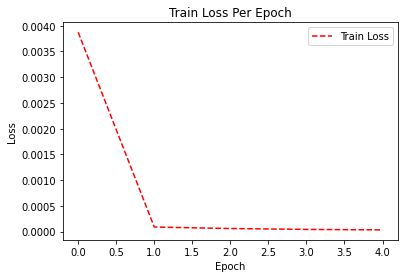

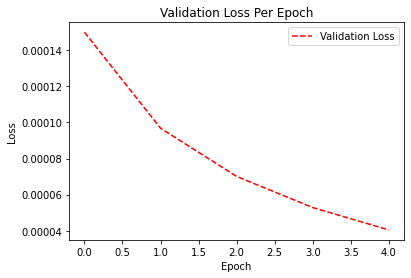

In [24]:
  # Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


model = LSTM(
    input_size=xfinai_config.lstm_model_config['input_size'],
    hidden_size=xfinai_config.lstm_model_config['hidden_size'],
    num_layers=xfinai_config.lstm_model_config['num_layers'],
    output_size=xfinai_config.lstm_model_config['output_size'],
    dropout_prob=xfinai_config.lstm_model_config['dropout_prob'],
    device = device
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), 
            lr=xfinai_config.lstm_model_config['learning_rate'],
            weight_decay=xfinai_config.lstm_model_config['weight_decay'])
epochs = xfinai_config.lstm_model_config['epochs']

print(model)

train_losses, validation_losses,trained_model = train(train_dataloader_ic, val_dataloader_ic, model, criterion, optimizer, epochs)

plot_loss(train_losses, epochs,'Train Loss')   
plot_loss(validation_losses, epochs,'Validation Loss')    

In [45]:
with torch.no_grad():
    train_losses = []
    train_y_real_list = np.array([])
    train_y_pred_list = np.array([])
    running_train_loss = 0.0
    train_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

    for idx, (x_batch, y_batch) in enumerate(train_dataloader_ic):

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        train_states = [state.detach() for state in train_states]
        y_pred, train_states = model(x_batch, train_states)
        
        train_y_real_list = np.append(train_y_real_list, y_batch.squeeze(1).cpu().numpy())
        train_y_pred_list = np.append(train_y_pred_list, y_pred.squeeze(1).cpu().numpy())
        
        train_loss = criterion(y_pred, y_batch)
        running_train_loss += train_loss.item()

    train_losses.append(running_train_loss / len(train_dataloader_ic))

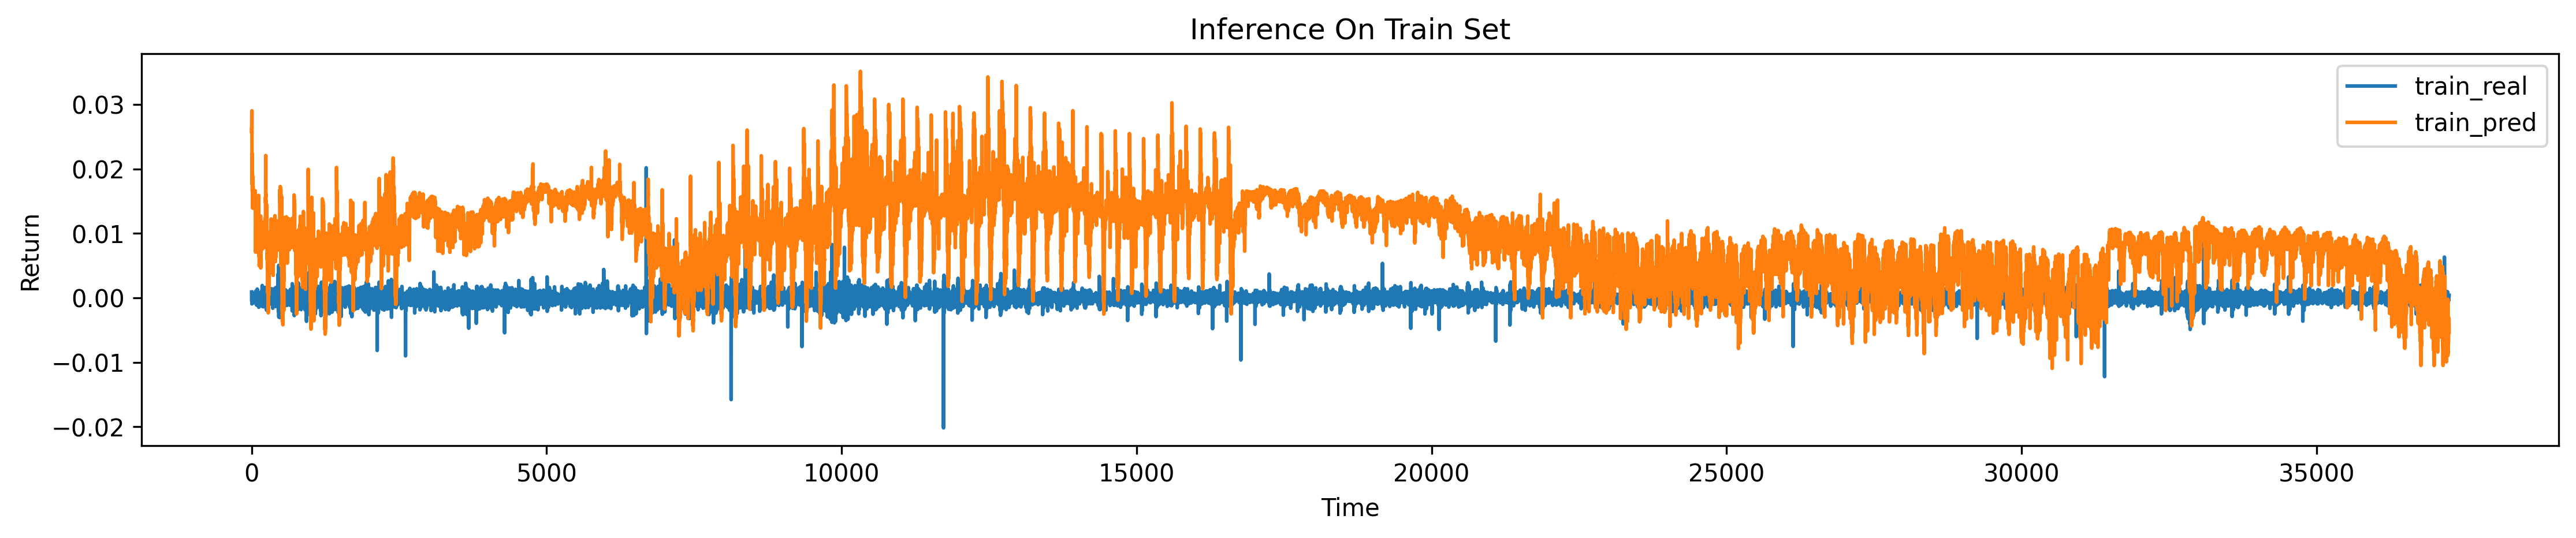

In [47]:
plt.figure(figsize=[18,3], dpi=300)
plt.plot(train_y_real_list,  label='train_real')
plt.plot(train_y_pred_list,  label='train_pred')
plt.legend()
plt.title(f"Inference On Train Set")
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

In [37]:
with torch.no_grad():
    val_losses = []
    val_y_real_list = np.array([])
    val_y_pred_list = np.array([])
    running_val_loss = 0.0
    val_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

    for idx, (x_batch, y_batch) in enumerate(val_dataloader_ic):

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        val_states = [state.detach() for state in val_states]
        y_pred, val_states = model(x_batch, val_states)
        
        val_y_real_list = np.append(val_y_real_list, y_batch.squeeze(1).cpu().numpy())
        val_y_pred_list = np.append(val_y_pred_list, y_pred.squeeze(1).cpu().numpy())
        
        val_loss = criterion(y_pred, y_batch)
        running_val_loss += val_loss.item()

    val_losses.append(running_val_loss / len(val_dataloader_ic))

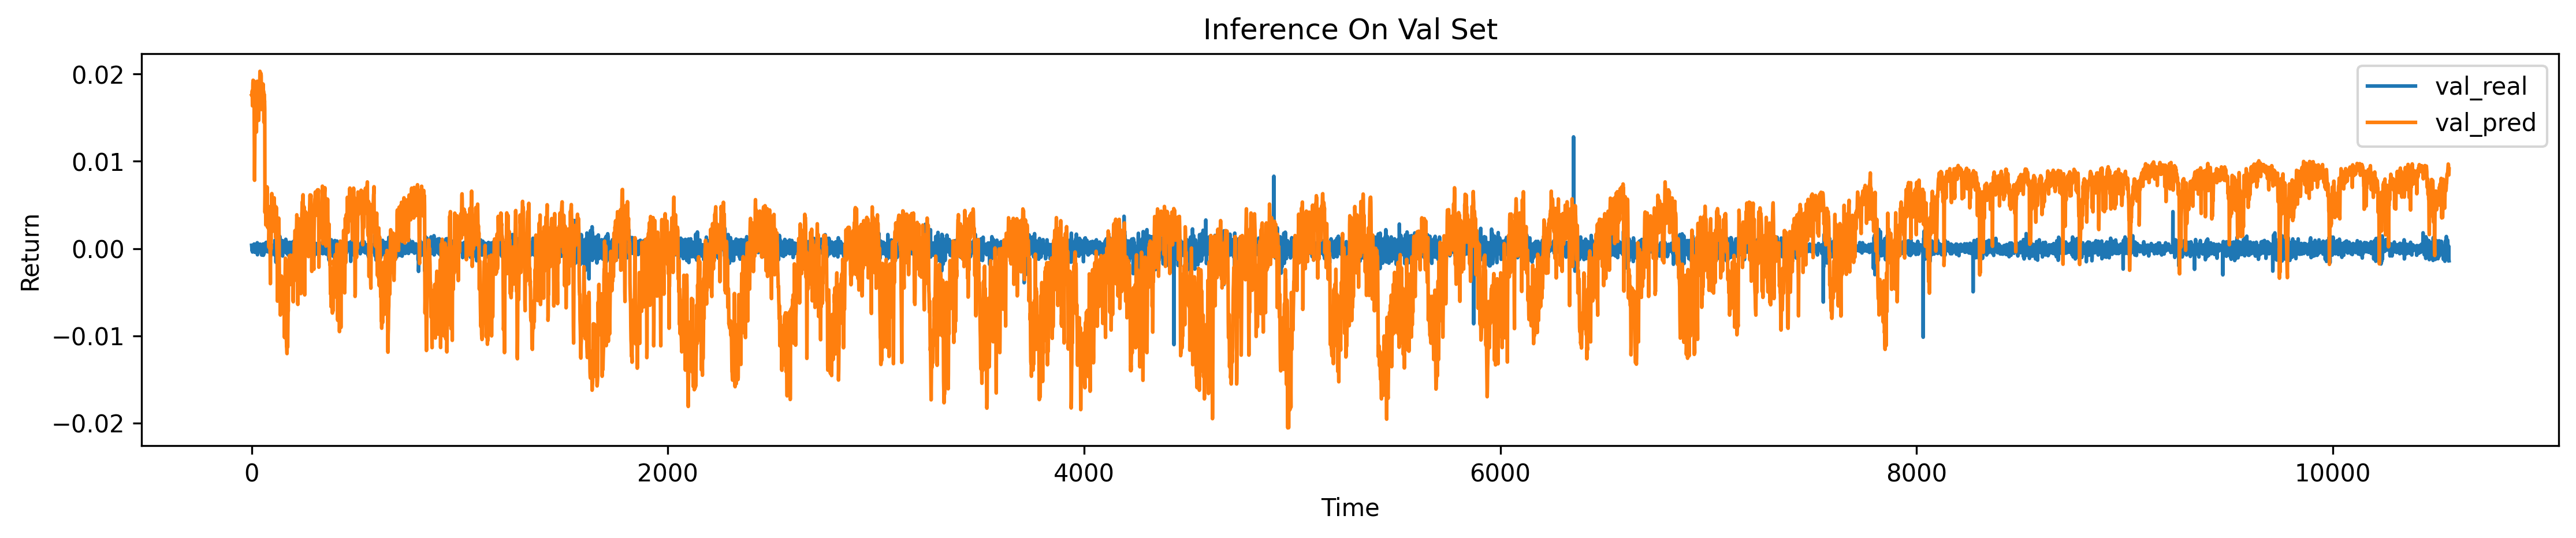

In [43]:
plt.figure(figsize=[18,3], dpi=300)
plt.plot(val_y_real_list,  label='val_real')
plt.plot(val_y_pred_list,  label='val_pred')
plt.legend()
plt.title(f"Inference On Val Set")
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

In [31]:
with torch.no_grad():
    test_losses = []
    test_y_real_list = np.array([])
    test_y_pred_list = np.array([])
    running_test_loss = 0.0
    test_states = model.init_hidden_states(xfinai_config.lstm_model_config['batch_size'])

    for idx, (x_batch, y_batch) in enumerate(test_dataloader_ic):

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        test_states = [state.detach() for state in test_states]
        y_pred, test_states = model(x_batch, test_states)
        
        test_y_real_list = np.append(test_y_real_list, y_batch.squeeze(1).cpu().numpy())
        test_y_pred_list = np.append(test_y_pred_list, y_pred.squeeze(1).cpu().numpy())
        
        test_loss = criterion(y_pred, y_batch)
        running_test_loss += test_loss.item()

    test_losses.append(running_test_loss / len(test_dataloader_ic))

In [44]:
plt.figure(figsize=[18,3], dpi=300)
plt.plot(test_y_real_list, label='test_real')
plt.plot(test_y_pred_list, label='test_pred')
plt.legend()
plt.title(f"Inference On Test Set")
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

NameError: name 'test_y_real_list' is not defined

<Figure size 5400x900 with 0 Axes>